In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
# Downloading video dataset
file_id = '1x6aUwQPBkNBOdOBRUOPlv23lrAKdgtam'
destination = '/content/dataset.mp4'
download_file_from_google_drive(file_id, destination)

In [4]:
import cv2
import os
import glob
import time

vid = cv2.VideoCapture("/content/dataset.mp4")

currentframe=1
count = 0
if not os.path.exists('data'):
    os.makedirs('data')

image = 1

while(True):
    success, frame = vid.read()
    count += 1
    # cv2.imwrite('./roughdata/frame' + str(currentframe) + '.jpg', frame)

    if count%10 == 0: # to limit the number of frames.
      gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      gray_image = gray_image[123:940, 239:2155]
      # crop = gray_image[10:80, :] 
      cv2.imwrite('./data/frame' + str(image) + '.jpg', gray_image)
      image += 1
      # cv2.imwrite('./roughdata/frame' + str(currentframe) + '.jpg', frame)

    if count > 720:
        break

    currentframe += 1

# webCam.release()
cv2.destroyAllWindows()
print(count)

721


In [5]:
import numpy as np
def pdf_value(x1,u1,sigma1):
  p=((x1-u1)*(x1-u1))/(2*sigma1*sigma1)
  t = (1/np.sqrt((2*3.14*sigma1*sigma1)))*(np.exp(-p))
  return t


def Gaussian_Mixture(x,u1,sigma1,u2,sigma2,w1,w2):
  mean1=u1
  mean2=u2
  weight1=w1
  weight2=w2
  SD1=sigma1
  SD2=sigma2
  count=0
  while (True):
    m1=mean1
    m2=mean2
    we1=weight1
    we2=weight2
    si1=SD1
    si2=SD2
    count=count+1

    # print(mean1,SD1,mean2,SD2,weight1,weight2)

    prob_array_cluster1=[]  # pdf
    prob_array_cluster2=[]
    for i in range(len(x)):
      prob_array_cluster1.append(pdf_value(x[i],mean1,SD1)) # calculating the pdf values coorsponding to each entry in x
      prob_array_cluster2.append(pdf_value(x[i],mean2,SD2))

    prob_element_in_cluster1=[] #  b_k
    prob_element_in_cluster2=[]
    for i in range(len(x)):
      # calculating bayers probability of x[i] belonging to both the clusters
      prob_element_in_cluster1.append((prob_array_cluster1[i]*weight1)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))
      prob_element_in_cluster2.append((prob_array_cluster2[i]*weight2)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))
    
    weight1=sum(prob_element_in_cluster1)/2  # updating the weights
    weight2=sum(prob_element_in_cluster2)/2

    d1=0  # sigma
    d2=0
    for i in range(len(x)):
      d1 = d1+prob_element_in_cluster1[i]*(x[i]-mean1)*(x[i]-mean1)
      d2 = d2+prob_element_in_cluster2[i]*(x[i]-mean2)*(x[i]-mean2)
    SD1=np.sqrt(d1/(2*weight1)) # upadting the varience/standard deviation
    SD2=np.sqrt(d2/(2*weight2))

    t1=0   # u_k
    t2=0
    for i in range(len(x)):
      t1 = t1+prob_element_in_cluster1[i]*x[i]
      t2 = t2+prob_element_in_cluster2[i]*x[i]
    mean1=t1/(2*weight1)
    mean2=t2/(2*weight2) # updating the mean values
    # convergence condition
    if (abs(mean1-m1)<0.1 or abs(mean2-m2)<0.1 or mean1>10000000 or mean2>10000000 or weight1>10000000 or weight1>10000000 or SD1>1000000 or SD2>10000000 or count>15):
      if count>15:
        return (sum(x)/len(x)) # if the algorithm doesnt converge, mean is returned as the output
        # return 255
      
      elif weight1>weight2:
        # print(mean1)
        #print(mean1, mean2)
        return mean1
        
      else:
        # print(mean2)
        #print(mean1, mean2)
        return mean2

In [6]:
import fnmatch
array = []
IMAGE_DIR = '/content/data'

image_names = []
image_dictionary = []

image_1D = []
for root, dirnames, filenames in os.walk(IMAGE_DIR):
    for filename in fnmatch.filter(filenames, "*.*"):
        image_names.append(os.path.join(root, filename))

for idx,image_name in enumerate(image_names):
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    # img.reshape()
    img = cv2.resize(img, (240,108), interpolation = cv2.INTER_AREA)
    array.append(img)

In [7]:

count = 0
# final_array = np.zeros((240,108))
final_array = np.zeros((108,240))


for i in range(len(array[0])): #rows
  for j in range(len(array[0][0])): #cols
    x = []
    for e in array: #frames
      x.append(e[i][j])
    summ = sum(x)
    avg = summ/len(x)
    xx = (Gaussian_Mixture(x,(avg),3,(avg*2),4,1/2,1/2)) # appling gaussian mixture to each pixel location values across all the frames to generate the background 
    final_array[i][j] = xx; # Extracted background
# print(final_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


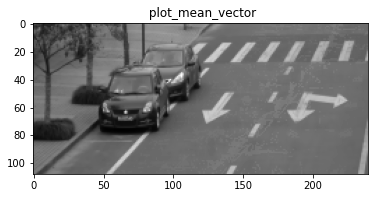

In [8]:
import matplotlib.pyplot as plt 
fig,axarr = plt.subplots()
axarr.set_title(" plot_mean_vector")
# avg_image = np.reshape(final_array, (240,108))

axarr.imshow(final_array, cmap=plt.cm.gray)

In [9]:
image=cv2.imread('/content/data/frame6.jpg')
image2 = cv2.resize(image, (240,108),
               interpolation = cv2.INTER_NEAREST)
gray_image = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
dim1 = gray_image.shape
# print(dim1)
dim = final_array.shape
# print(dim)
# cv2_imshow(image2)
# cv2_imshow(final_array)
gray_image = np.asarray(gray_image, np.float64)
final_array = np.asarray(final_array, np.float64)
image_final = cv2.absdiff(gray_image, final_array)

In [10]:
from google.colab.patches import cv2_imshow

if not os.path.exists('answer'):
    os.makedirs('answer')
    
img_array = []

for p in range(1,len(array)+1):
  img1 = cv2.imread('/content/data/frame' + str(p) + '.jpg')
  gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  # print((np.shape(gray_image)))
  gray_image = cv2.resize(gray_image, (240,108), interpolation = cv2.INTER_AREA)

  # subtracting the background from the original frames  
  m = np.zeros((108,240))
  for i in range(len(final_array)):
    for j in range(len(final_array[0])):
      diff = final_array[i][j] - gray_image[i][j]
      if (abs(diff)>30): #threshold to check similarity betwwen two pixels for pixel classification as either foreground or background
        m[i][j]= gray_image[i][j]
      else:
        m[i][j] = 100
  # print(m)
  cv2.imwrite('./answer/frame' + str(p) + '.jpg', m)
  height, width = m.shape
  size = (width,height)
  img_array.append(m)
  # cv2_imshow(m)
   

In [11]:
import natsort 
import cv2
import numpy as np
import glob

# sorting foreground frames for video generation

img_array = []
for filename in glob.glob('/content/answer/*.jpg'):

    img_array.append(filename)
sorted_arr = natsort.natsorted(img_array)

In [12]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(sorted_arr)):
  out.write(cv2.imread(sorted_arr[i]))
out.release()

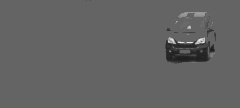

In [13]:
cv2_imshow(cv2.imread('/content/answer/frame27.jpg')) # Output

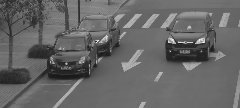

In [14]:
img = cv2.imread('/content/data/frame27.jpg')  # Raw Frame
img = cv2.resize(img, (240,108))
cv2_imshow(img)

In [15]:
from google.colab.patches import cv2_imshow

if not os.path.exists('frames_for_comparison'):
    os.makedirs('frames_for_comparison')
    
img_array = []

for p in range(1,len(array)+1):
  img1 = cv2.imread('/content/data/frame' + str(p) + '.jpg')
  gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  # print((np.shape(gray_image)))
  gray_image = cv2.resize(gray_image, (240,108), interpolation = cv2.INTER_AREA)


  m = np.zeros((108,240))
  for i in range(len(final_array)):
    for j in range(len(final_array[0])):
      diff = final_array[i][j] - gray_image[i][j] # # subtracting the background from the original frames to generate only black and white foreground for comparison with built-in function
      if (abs(diff)>30):
        m[i][j]= 255
      else:
        m[i][j] = 0
  # print(m)
  cv2.imwrite('./frames_for_comparison/frame' + str(p) + '.jpg', m)
  height, width = m.shape
  size = (width,height)
  img_array.append(m)

our foreground


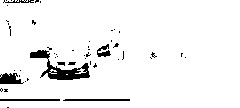

in-built function foreground


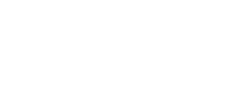

our foreground


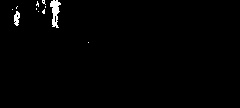

in-built function foreground


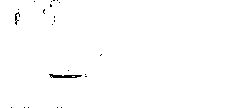

our foreground


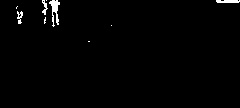

in-built function foreground


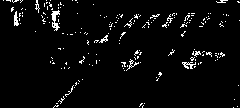

our foreground


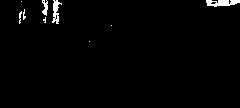

in-built function foreground


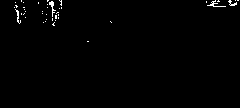

our foreground


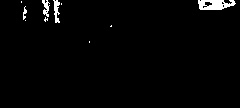

in-built function foreground


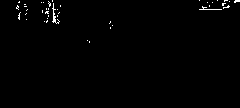

our foreground


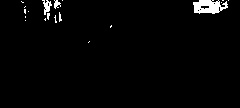

in-built function foreground


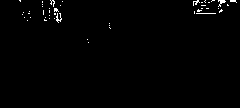

our foreground


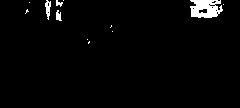

in-built function foreground


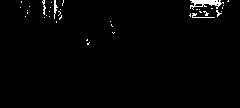

our foreground


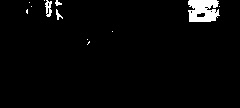

in-built function foreground


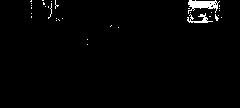

our foreground


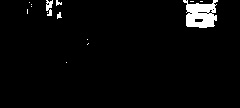

in-built function foreground


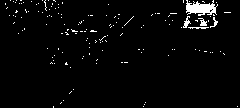

our foreground


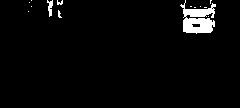

in-built function foreground


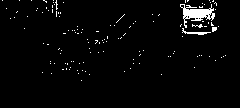

our foreground


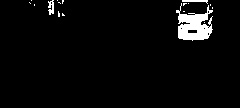

in-built function foreground


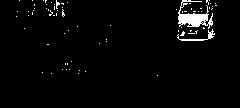

our foreground


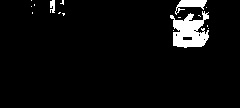

in-built function foreground


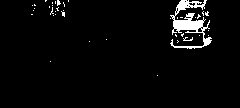

our foreground


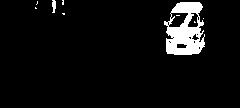

in-built function foreground


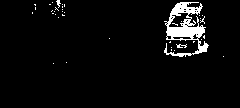

our foreground


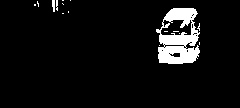

in-built function foreground


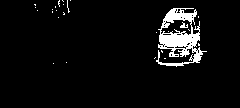

our foreground


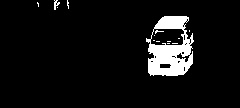

in-built function foreground


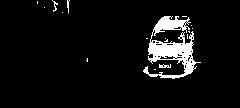

our foreground


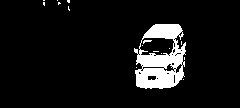

in-built function foreground


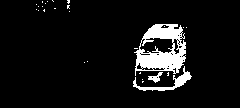

our foreground


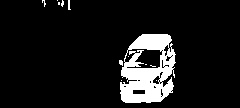

in-built function foreground


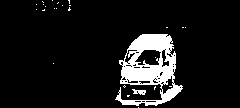

our foreground


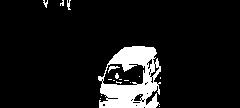

in-built function foreground


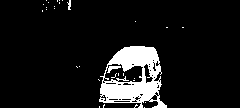

our foreground


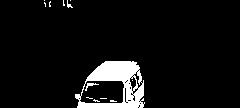

in-built function foreground


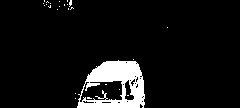

our foreground


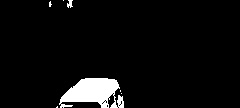

in-built function foreground


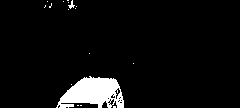

our foreground


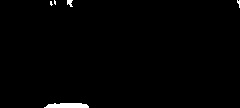

in-built function foreground


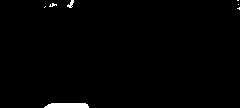

our foreground


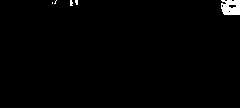

in-built function foreground


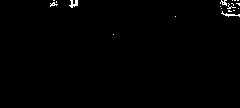

our foreground


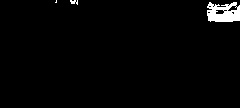

in-built function foreground


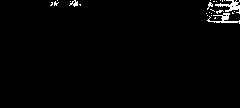

our foreground


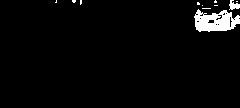

in-built function foreground


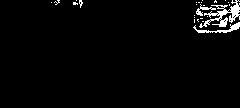

our foreground


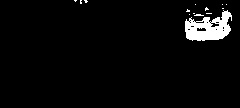

in-built function foreground


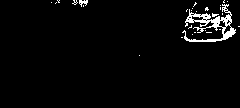

our foreground


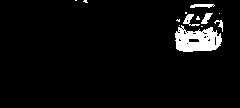

in-built function foreground


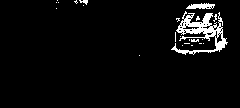

our foreground


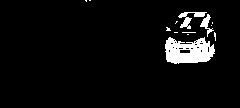

in-built function foreground


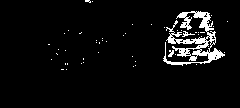

our foreground


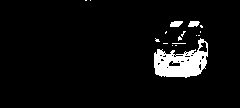

in-built function foreground


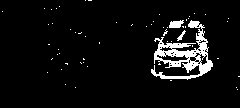

our foreground


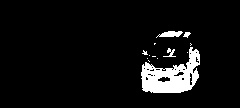

in-built function foreground


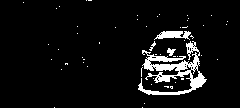

our foreground


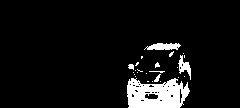

in-built function foreground


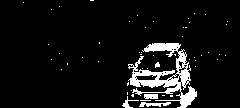

our foreground


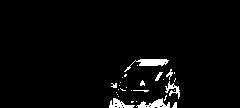

in-built function foreground


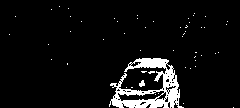

our foreground


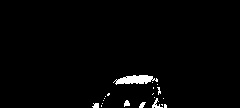

in-built function foreground


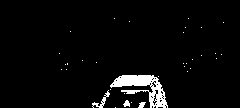

our foreground


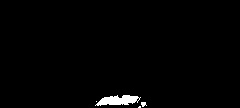

in-built function foreground


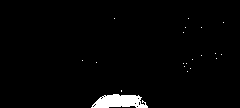

our foreground


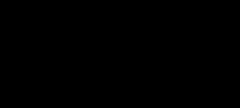

in-built function foreground


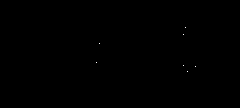

our foreground


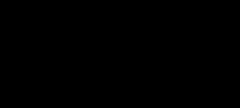

in-built function foreground


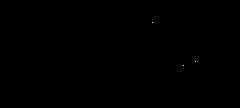

our foreground


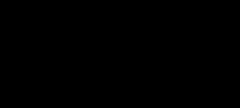

in-built function foreground


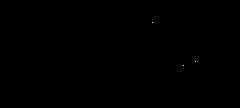

our foreground


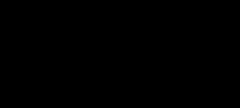

in-built function foreground


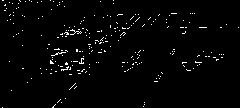

our foreground


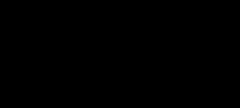

in-built function foreground


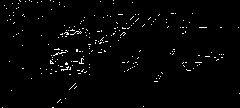

our foreground


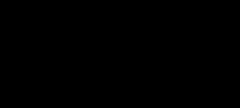

in-built function foreground


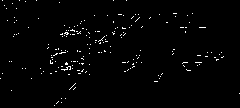

our foreground


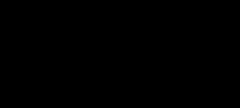

in-built function foreground


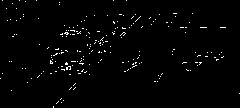

our foreground


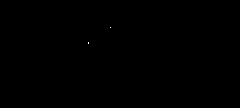

in-built function foreground


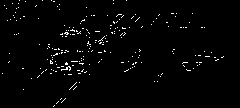

our foreground


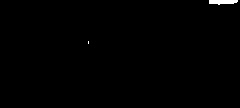

in-built function foreground


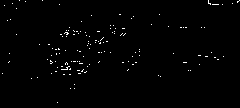

our foreground


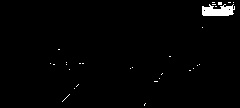

in-built function foreground


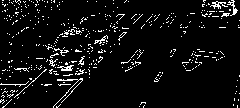

our foreground


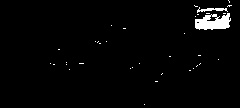

in-built function foreground


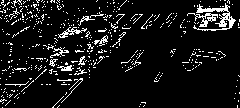

our foreground


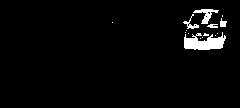

in-built function foreground


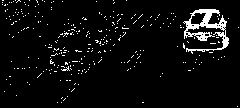

our foreground


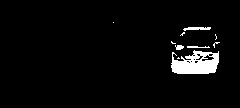

in-built function foreground


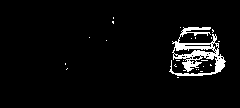

our foreground


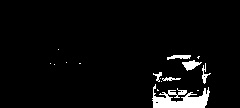

in-built function foreground


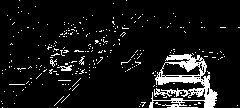

our foreground


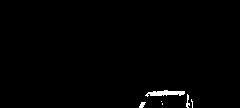

in-built function foreground


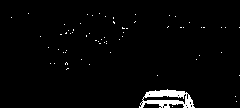

our foreground


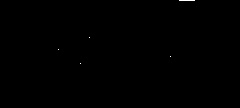

in-built function foreground


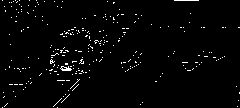

our foreground


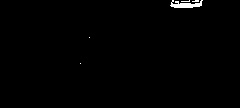

in-built function foreground


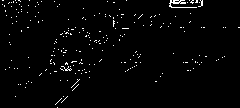

our foreground


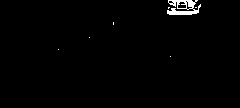

in-built function foreground


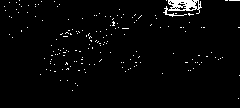

our foreground


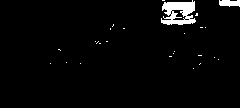

in-built function foreground


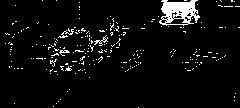

our foreground


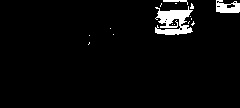

in-built function foreground


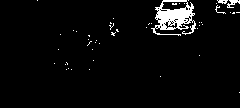

our foreground


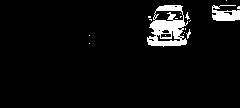

in-built function foreground


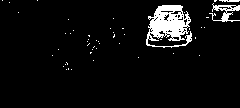

our foreground


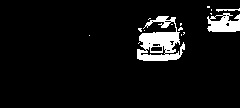

in-built function foreground


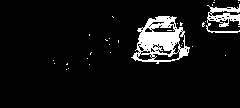

our foreground


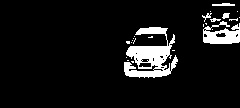

in-built function foreground


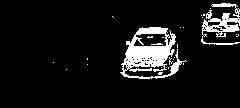

our foreground


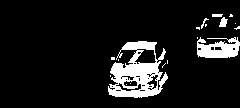

in-built function foreground


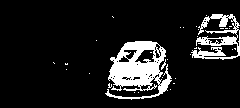

our foreground


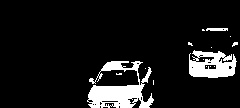

in-built function foreground


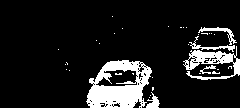

our foreground


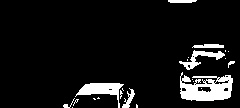

in-built function foreground


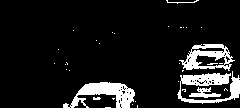

our foreground


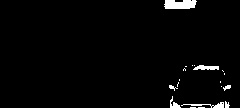

in-built function foreground


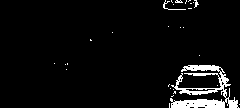

our foreground


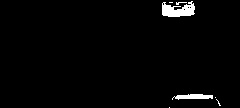

in-built function foreground


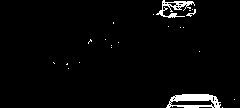

our foreground


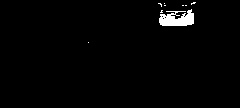

in-built function foreground


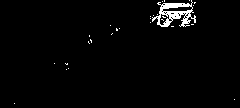

our foreground


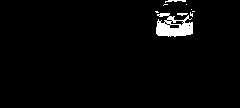

in-built function foreground


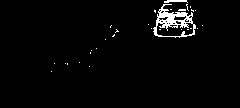

our foreground


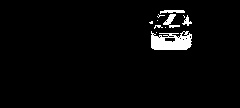

in-built function foreground


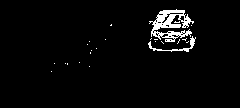

our foreground


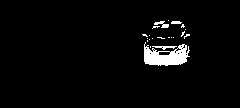

in-built function foreground


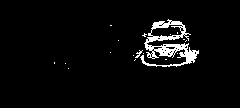

our foreground


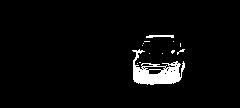

in-built function foreground


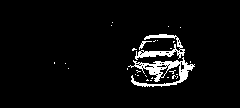

our foreground


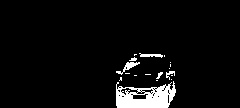

in-built function foreground


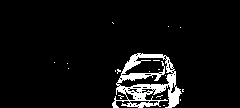

our foreground


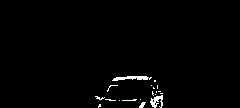

in-built function foreground


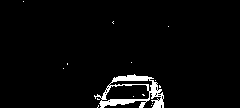

our foreground


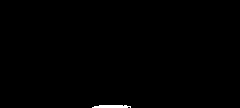

in-built function foreground


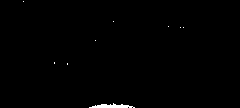

our foreground


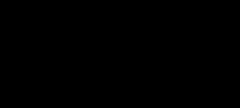

in-built function foreground


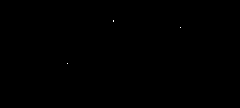

our foreground


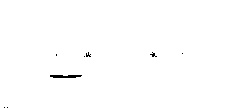

in-built function foreground


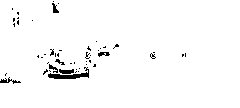

our foreground


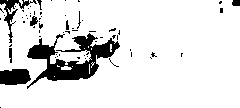

in-built function foreground


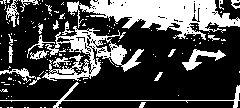

In [16]:
import cv2
import os
import math
import glob
import time
from skimage.metrics import mean_squared_error
import csv 
vid = cv2.VideoCapture("/content/dataset.mp4")
fgbg = cv2.createBackgroundSubtractorMOG2()

currentframe=1
count = 0

image = 1

from PIL import Image


RMSE=[]
while(True):
    success, frame = vid.read()
    count += 1

    if count%10 == 0:
      gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      gray_image = gray_image[123:940, 239:2155]
      fgmask = fgbg.apply(gray_image) # in-built function for foreground generation

        
      
      gray_image = cv2.resize(gray_image, (240,108))
      fgmask = cv2.resize(fgmask, (240,108))
      # fgmask = fgmask.convert('L')
      # fgmask = cv2.cvtColor(fgmask, cv2.COLOR_BGR2GRAY)
      # gray_image = cv2.cvtColor(fgmask, cv2.COLOR_BGR2GRAY)
      # cv2_imshow(frame)
      
      our_image = cv2.imread('/content/frames_for_comparison/frame' + str(image) + '.jpg')
      our_image = cv2.cvtColor(our_image, cv2.COLOR_BGR2GRAY)
      print('our foreground')
      cv2_imshow(our_image)
      m = np.zeros((108,240))
      for i in range(len(final_array)):
        for j in range(len(final_array[0])):
          diff = fgmask[i][j]
          if (diff>10):
            m[i][j]= 255
          else:
            m[i][j] = 0
      print('in-built function foreground')
      cv2_imshow(m)
      dim1 = our_image.shape
      dim2 = gray_image.shape
      RMSE.append(math.sqrt(mean_squared_error(our_image, m))) # comparing both the generated foregrounds
      # print(mean_squared_error(fgmask, cv2.imread('/content/answer/frame' + str(image) + '.jpg') ) )

      # crop = gray_image[10:80, :] 
      # cv2.imwrite('./data/frame' + str(image) + '.jpg', gray_image)
      image += 1
      # cv2.imwrite('./roughdata/frame' + str(currentframe) + '.jpg', frame)

    if count > 720:
        break

    currentframe += 1

# webCam.release()
a=RMSE[21:len(RMSE)-3] # storing the foregrounds in an array
cv2.destroyAllWindows()

In [17]:
# Storing RMSE values in csv file
x=[]
for i in a:
  x.append([i])
import csv
with open("MSE.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(x)
minimum=min(a)
maximum=max(a)


In [18]:
print("Maximum MSE between two frames is: " + str(maximum)) 
print("Minimum MSE between two frames is: " + str(minimum))
# It will change as the total number of frames change. 
# In the report, MSE is reported when all the video frames are taken(696).
# Here, the result is only for 72 frames.

Maximum MSE between two frames is: 74.70160651172168
Minimum MSE between two frames is: 2.743363203563587
